In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('cluster').getOrCreate()

# Exploratory Analysis

In [3]:
anime_rating_data = spark.read.csv('rating.csv', inferSchema=True, header=True)
anime_data = spark.read.csv('anime.csv', inferSchema=True, header = True)

In [4]:
#Due to computational Reason taking only 10000 users and 10000 animes
anime_rating_data = anime_rating_data[anime_rating_data['user_id'] <= 10000 ]
anime_data = anime_data[anime_data['anime_id'] <= 10000]

In [5]:
anime_rating_data.describe().show()
anime_rating_data = anime_rating_data.dropna()
anime_rating_data = anime_rating_data.dropDuplicates(subset = ('user_id', 'anime_id', 'rating'))
print("The number of columns in dataset is " + str(len(anime_rating_data.columns)))

+-------+------------------+-----------------+------------------+
|summary|           user_id|         anime_id|            rating|
+-------+------------------+-----------------+------------------+
|  count|           1042697|          1042697|           1042697|
|   mean| 4997.520646937701|8877.468704714793| 6.161604953308584|
| stddev|2723.7881798718954|9019.430573731863|3.7017201292749244|
|    min|                 1|                1|                -1|
|    max|             10000|            34325|                10|
+-------+------------------+-----------------+------------------+

The number of columns in dataset is 3


In [6]:
anime_rating_data_pandas = anime_rating_data.toPandas()
anime_data_pandas = anime_data.toPandas()

In [7]:
anime_rating_details_data = anime_data_pandas.merge(anime_rating_data_pandas, on = 'anime_id', how = 'inner')
anime_rating_details_data = anime_rating_details_data.rename(columns = {"rating_x" : "total_rating", "rating_y" : "user_rating"})
highest_rated_anime = pd.DataFrame(anime_rating_details_data.groupby('name')['total_rating'].max().sort_values(ascending=False)[:15]).reset_index()
print(highest_rated_anime.head())

                               name  total_rating
0  Fullmetal Alchemist: Brotherhood          9.26
1                       Steins;Gate          9.17
2                     Gintama&#039;          9.16
3              Ginga Eiyuu Densetsu          9.11
4              Clannad: After Story          9.06


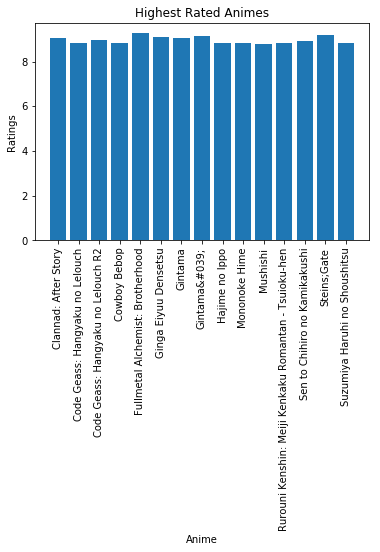

In [8]:
plt.bar(highest_rated_anime['name'], highest_rated_anime['total_rating'], tick_label = highest_rated_anime['name'])
plt.xlabel('Anime')
plt.ylabel('Ratings')
plt.xticks(highest_rated_anime['name'], rotation = 'vertical')
plt.title('Highest Rated Animes')
plt.show()

In [9]:
anime_type_details_data = pd.DataFrame(anime_rating_details_data.groupby('type').size()).reset_index()
anime_type_details_data = anime_type_details_data.rename(columns={0: "anime_count"})
print(anime_type_details_data.head())

      type  anime_count
0    Movie       114227
1    Music         2078
2      ONA         5505
3      OVA        77689
4  Special        45027


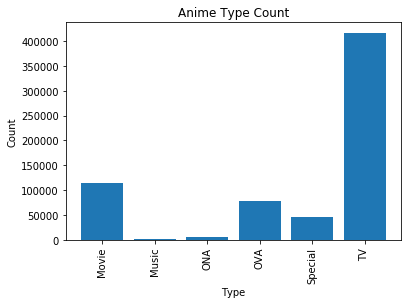

In [10]:
plt.bar(anime_type_details_data['type'], anime_type_details_data['anime_count'], tick_label = anime_type_details_data['type'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(anime_type_details_data['type'], rotation = 'vertical')
plt.title('Anime Type Count')
plt.show()

In [11]:
anime_episodes_number = pd.DataFrame(anime_rating_details_data.groupby('name')['episodes'].max().sort_values(ascending=False)[:15]).reset_index()
print(anime_episodes_number.head())

                                         name episodes
0                               Mister Ajikko       99
1  Tatakae! Chou Robot Seimeitai Transformers       98
2          Majime ni Fumajime Kaiketsu Zorori       97
3                             Dragon Ball Kai       97
4                             Tetsujin 28-gou       96


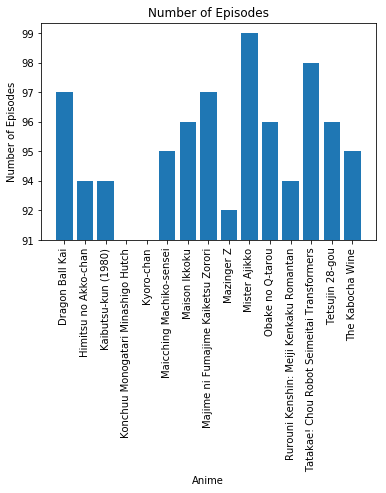

In [12]:
plt.bar(anime_episodes_number['name'], anime_episodes_number['episodes'], tick_label = anime_episodes_number['name'])
plt.xlabel('Anime')
plt.ylabel('Number of Episodes')
plt.xticks(anime_episodes_number['name'], rotation = 'vertical')
plt.title('Number of Episodes')
plt.show()

# Recommendation System

In [13]:
training, test = anime_rating_data.randomSplit([0.8, 0.2])

In [14]:
als = ALS(maxIter=10, regParam=0.01, userCol = 'user_id', itemCol = 'anime_id', ratingCol = 'rating', coldStartStrategy="drop")

In [15]:
model = als.fit(training)
predictions = model.transform(test)
predictions.show()

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|   7726|     148|     8|  7.969903|
|   6223|     148|    10| 2.1685557|
|   2837|     148|     6| 4.5439405|
|   5428|     148|    -1|  -9.44039|
|   1239|     148|    10| 2.1513515|
|   6569|     148|     6|  5.454629|
|   7345|     148|     5|  7.130377|
|   5345|     463|     8|   5.84532|
|   6866|     463|     7|  6.993144|
|   4859|     463|    -1|-0.9657736|
|   8231|     463|     6| 6.4484763|
|    857|     463|     7|  8.350036|
|   5251|     463|    -1|-0.9983213|
|   5543|     463|    10|   9.25627|
|   5571|     463|    -1| -1.025047|
|   4773|     463|     9|  7.582809|
|   8423|     463|    -1| 0.9191793|
|   1675|     463|     8|  7.133697|
|   3152|     463|     6| 6.5351067|
|   4321|     463|     7| 6.9575787|
+-------+--------+------+----------+
only showing top 20 rows



In [16]:
modelevaluator = RegressionEvaluator(metricName = 'mse', labelCol = 'rating', predictionCol ='prediction')
mse = modelevaluator.evaluate(predictions)
print(mse)

5.711838730598964


In [17]:
single_user = test.filter(test['user_id']==5916).select(['anime_id','user_id'])
single_user.show()

+--------+-------+
|anime_id|user_id|
+--------+-------+
|    1519|   5916|
|    3032|   5916|
|     393|   5916|
|     427|   5916|
|     479|   5916|
|    5256|   5916|
|    2685|   5916|
|    2904|   5916|
|    2144|   5916|
|    1686|   5916|
|    2020|   5916|
|    3033|   5916|
|     121|   5916|
|     466|   5916|
|     481|   5916|
|     223|   5916|
|    1816|   5916|
|    1120|   5916|
|    3031|   5916|
|     834|   5916|
+--------+-------+
only showing top 20 rows



In [18]:
anime_recommendations = model.transform(single_user)
anime_recommendations.orderBy('prediction', ascending = False).show()
anime_join = anime_recommendations.join(anime_data, anime_recommendations.anime_id == anime_data.anime_id)
anime_join.show(5)

+--------+-------+----------+
|anime_id|user_id|prediction|
+--------+-------+----------+
|    2685|   5916|  9.750684|
|    2904|   5916|  9.556599|
|    2966|   5916|  9.247933|
|    1519|   5916|  9.153988|
|     121|   5916|  8.990497|
|     427|   5916|   8.78578|
|     479|   5916|  8.305604|
|     223|   5916|  8.300729|
|     177|   5916|   8.26258|
|    2020|   5916|  8.256365|
|    2107|   5916|  8.161304|
|     465|   5916|  8.131595|
|      68|   5916|  8.092404|
|     393|   5916|  8.041121|
|    1686|   5916|  7.996961|
|     481|   5916| 7.7580595|
|    2386|   5916| 7.7338686|
|    2961|   5916|  7.653836|
|    3032|   5916| 7.5157495|
|     442|   5916| 7.4938045|
+--------+-------+----------+
only showing top 20 rows

+--------+-------+----------+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|user_id|prediction|anime_id|                name|               genre| type|episodes|rating|members|
+--------+-------+----------+---

## Data Preparation before clustering and classification

In [19]:
import numpy as np

each_genre_anime_rating = pd.DataFrame()
fantasy_anime_genres = anime_data_pandas[anime_data_pandas['genre'].str.contains('Fantasy')]
average_fantasy_genre_votes_per_user = anime_rating_data_pandas[anime_rating_data_pandas['anime_id'].isin(fantasy_anime_genres['anime_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(3)
each_genre_anime_rating = pd.concat([each_genre_anime_rating, average_fantasy_genre_votes_per_user], axis = 1)

adventure_anime_genres = anime_data_pandas[anime_data_pandas['genre'].str.contains('Adventure')]
average_adventure_genre_votes_per_user = anime_rating_data_pandas[anime_rating_data_pandas['anime_id'].isin(adventure_anime_genres['anime_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(3)
each_genre_anime_rating = pd.concat([each_genre_anime_rating, average_adventure_genre_votes_per_user], axis = 1)
each_genre_anime_rating.columns = ['average_fantasy_rating','average_adventure_rating']


only_genre_lover_dataset = each_genre_anime_rating.dropna()
only_genre_lover_dataset = only_genre_lover_dataset[only_genre_lover_dataset['average_fantasy_rating'] > 0]
only_genre_lover_dataset = only_genre_lover_dataset[only_genre_lover_dataset['average_adventure_rating'] > 0]

average_fantasy_lover_rating = only_genre_lover_dataset['average_fantasy_rating'].mean()
average_adventure_lover_rating = only_genre_lover_dataset['average_adventure_rating'].mean()

only_genre_lover_dataset['user_id'] = only_genre_lover_dataset.index
export_temp_csv = only_genre_lover_dataset.to_csv('temp.csv')

# Classification

In [20]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from numpy import array

def mapClass(fantasy_rating, adventure_rating):
    if (fantasy_rating > average_fantasy_lover_rating) and (adventure_rating > average_adventure_lover_rating):
        return 0
    elif (fantasy_rating < average_fantasy_lover_rating) and (adventure_rating > average_adventure_lover_rating):
        return 1
    elif (fantasy_rating > average_fantasy_lover_rating) and (adventure_rating < average_adventure_lover_rating):
        return 2
    else:
        return 3
    
def createLabeledPoints(fields):
    fantasy_rating = float(fields[1])
    adventure_rating = float(fields[2])
    fan_class = mapClass(fantasy_rating, adventure_rating)
    return LabeledPoint(fan_class, array([fantasy_rating,adventure_rating]))

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, mean, when

sc = spark.sparkContext
raw_class_data = sc.textFile('temp.csv')
class_headers = raw_class_data.first()
header = sc.parallelize([class_headers])
only_data = raw_class_data.subtract(header)

In [22]:
class_data = only_data.map(lambda x: x.split(","))
trainingData = class_data.map(createLabeledPoints)

In [23]:
trainingData.take(5)

[LabeledPoint(0.0, [8.333,8.333]),
 LabeledPoint(3.0, [5.381,6.227]),
 LabeledPoint(0.0, [8.0,8.667]),
 LabeledPoint(0.0, [10.0,10.0]),
 LabeledPoint(3.0, [1.273,0.208])]

In [24]:
model = LogisticRegressionWithLBFGS.train(trainingData, iterations=10, numClasses=4)

In [25]:
test = [array([8, 10]), 
        array([9.83, 7]), 
        array([4.5, 10])]

In [26]:
testData = sc.parallelize(test)
predictions = model.predict(testData)

In [27]:
fan_category = ['Fantasy And Adventure Lover', 'Adventure Lover', 'Fantasy Lover', 'No Rating Category']
results = predictions.collect()
for result in results:
    print(fan_category[result])

Fantasy And Adventure Lover
Fantasy And Adventure Lover
Adventure Lover


In [28]:
labelsAndPreds = trainingData.map(lambda p: (p.label, model.predict(p.features)))
trainingError = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count()/ float(trainingData.count())
print("Training Error = " + str(trainingError))

Training Error = 0.43212185996793157


# Clustering

In [29]:
feature_col = ['average_fantasy_rating', 'average_adventure_rating']
spark_genre_lover_dataframe = spark.createDataFrame(only_genre_lover_dataset)

In [30]:
for col in spark_genre_lover_dataframe.columns:
    if col in feature_col:
        spark_genre_lover_dataframe = spark_genre_lover_dataframe.withColumn(col, spark_genre_lover_dataframe[col].cast('float'))

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_col, outputCol="features")
dataframe_kmeans = assembler.transform(spark_genre_lover_dataframe).select('user_id', 'features')
dataframe_kmeans.show(10)

+-------+--------------------+
|user_id|            features|
+-------+--------------------+
|      3|[7.61499977111816...|
|      5|[4.42299985885620...|
|      7|[8.07699966430664...|
|      8|          [8.0,10.0]|
|     10|         [10.0,10.0]|
|     11|[7.02600002288818...|
|     12|[8.33300018310546...|
|     14|[7.16699981689453...|
|     17|[5.38100004196167...|
|     18|[9.83300018310546...|
+-------+--------------------+
only showing top 10 rows



Text(0,0.5,'cost')

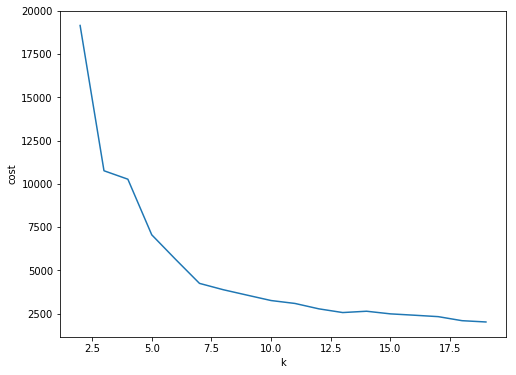

In [32]:
%matplotlib inline
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(dataframe_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(dataframe_kmeans)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [33]:
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(dataframe_kmeans)

In [34]:
cluster_centers = model.clusterCenters()

print("#### The cluster centers are ####")
for centre in cluster_centers:
    print(centre)

#### The cluster centers are ####
[ 8.62171157  8.76197311]
[ 2.93756942  2.91325585]
[ 6.97170768  7.08570864]


In [35]:
wsse = model.computeCost(dataframe_kmeans)
print("###### the wsse  value is ####" + str(wsse))

###### the wsse  value is ####10475.848708057145


In [36]:
prediction_cluster_result = model.transform(dataframe_kmeans)
prediction_cluster_result.show(20)

+-------+--------------------+----------+
|user_id|            features|prediction|
+-------+--------------------+----------+
|      3|[7.61499977111816...|         2|
|      5|[4.42299985885620...|         1|
|      7|[8.07699966430664...|         0|
|      8|          [8.0,10.0]|         0|
|     10|         [10.0,10.0]|         0|
|     11|[7.02600002288818...|         2|
|     12|[8.33300018310546...|         0|
|     14|[7.16699981689453...|         2|
|     17|[5.38100004196167...|         2|
|     18|[9.83300018310546...|         0|
|     19|[8.0,8.6669998168...|         0|
|     20|         [10.0,10.0]|         0|
|     21|[7.57100009918212...|         2|
|     22|          [4.5,10.0]|         2|
|     23|[9.55200004577636...|         0|
|     24|           [3.0,7.0]|         2|
|     27|[8.77799987792968...|         0|
|     29|[7.25500011444091...|         2|
|     30|[9.42899990081787...|         0|
|     31|[3.85700011253356...|         1|
+-------+--------------------+----